# Data Task

##  Environment Setup

In [1]:
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import ElasticNet, Ridge
from sklearn.metrics import mean_squared_error, r2_score, classification_report
from sklearn.model_selection import cross_val_score

from pprint import pprint

%matplotlib inline

In [2]:
SEED = 1134
np.random.seed(SEED)

## Data Look Up & Preprocessing

In [3]:
df = pd.read_csv("data/education_career_success.csv")
df.head(3)

,Student_ID,Age,Gender,High_School_GPA,SAT_Score,University_Ranking,University_GPA,Field_of_Study,Internships_Completed,Projects_Completed,Certifications,Soft_Skills_Score,Networking_Score,Job_Offers,Starting_Salary,Career_Satisfaction,Years_to_Promotion,Current_Job_Level,Work_Life_Balance,Entrepreneurship
0,S00001,24,Male,3.58,1052,291,3.96,Arts,3,7,2,9,8,5,27200.0,4,5,Entry,7,No
1,S00002,21,Other,2.52,1211,112,3.63,Law,4,7,3,8,1,4,25000.0,1,1,Mid,7,No
2,S00003,28,Female,3.42,1193,715,2.63,Medicine,4,8,1,1,9,0,42400.0,9,3,Entry,7,No


Check for missing values (we do not have any):

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Student_ID             5000 non-null   object 
 1   Age                    5000 non-null   int64  
 2   Gender                 5000 non-null   object 
 3   High_School_GPA        5000 non-null   float64
 4   SAT_Score              5000 non-null   int64  
 5   University_Ranking     5000 non-null   int64  
 6   University_GPA         5000 non-null   float64
 7   Field_of_Study         5000 non-null   object 
 8   Internships_Completed  5000 non-null   int64  
 9   Projects_Completed     5000 non-null   int64  
 10  Certifications         5000 non-null   int64  
 11  Soft_Skills_Score      5000 non-null   int64  
 12  Networking_Score       5000 non-null   int64  
 13  Job_Offers             5000 non-null   int64  
 14  Starting_Salary        5000 non-null   float64
 15  Care

Normalize some numeric features and remove the unnecessary ones:

In [5]:
# from the description of the dataset on kaggle
df['High_School_GPA'] = df['High_School_GPA'] / 4.0
df['SAT_Score'] = df['SAT_Score'] / 1600
df['University_GPA'] = df['University_GPA'] / 4.0
df['University_Ranking'] = df['University_Ranking'] / 1000

df.drop(['Student_ID'], axis=1, inplace=True)

In [6]:
df.describe()

,Age,High_School_GPA,SAT_Score,University_Ranking,University_GPA,Internships_Completed,Projects_Completed,Certifications,Soft_Skills_Score,Networking_Score,Job_Offers,Starting_Salary,Career_Satisfaction,Years_to_Promotion,Work_Life_Balance
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,23.442200,0.749245,0.783645,0.504336,0.755007,1.982200,4.562800,2.512200,5.546000,5.538000,2.488800,50563.540000,5.578000,3.015800,5.482400
std,3.473712,0.143918,0.127018,0.291060,0.144012,1.408219,2.872927,1.703183,2.851159,2.850084,1.711859,14494.958207,2.871997,1.417446,2.883427
min,18.000000,0.500000,0.562500,0.001000,0.500000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,25000.000000,1.000000,1.000000,1.000000
25%,20.000000,0.625000,0.672500,0.256000,0.630000,1.000000,2.000000,1.000000,3.000000,3.000000,1.000000,40200.000000,3.000000,2.000000,3.000000
50%,23.000000,0.747500,0.785625,0.501500,0.757500,2.000000,5.000000,3.000000,6.000000,6.000000,2.000000,50300.000000,6.000000,3.000000,6.000000
75%,26.000000,0.875000,0.895000,0.759000,0.877500,3.000000,7.000000,4.000000,8.000000,8.000000,4.000000,60500.000000,8.000000,4.000000,8.000000
max,29.000000,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,5.000000,10.000000,10.000000,5.000000,101000.000000,10.000000,5.000000,10.000000


With correlations we do not observe any linear dependencies:

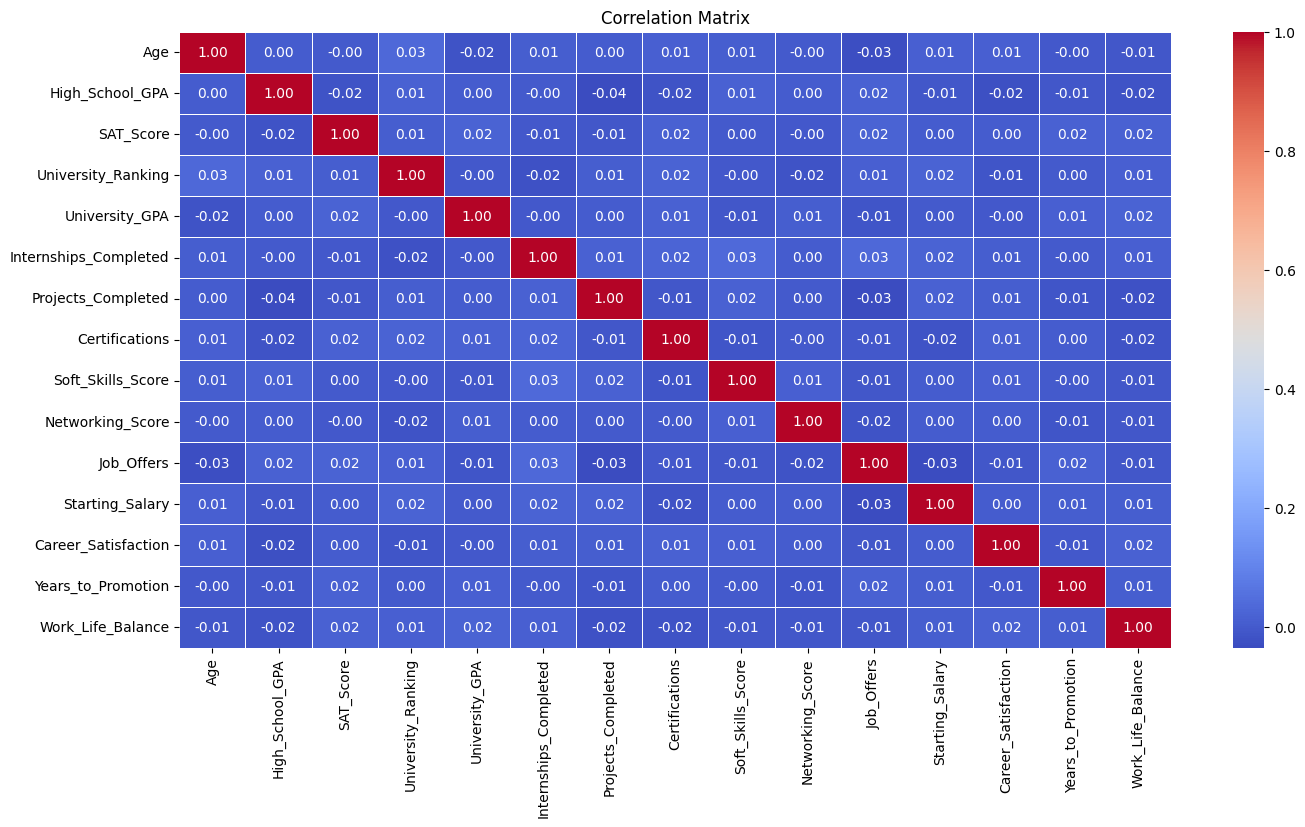

In [7]:
df_numeric = df.select_dtypes(include=['number'])  # <class 'pandas.core.frame.DataFrame'>
corr_matrix = df_numeric.corr()

plt.figure(figsize=(16, 8)) 
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()


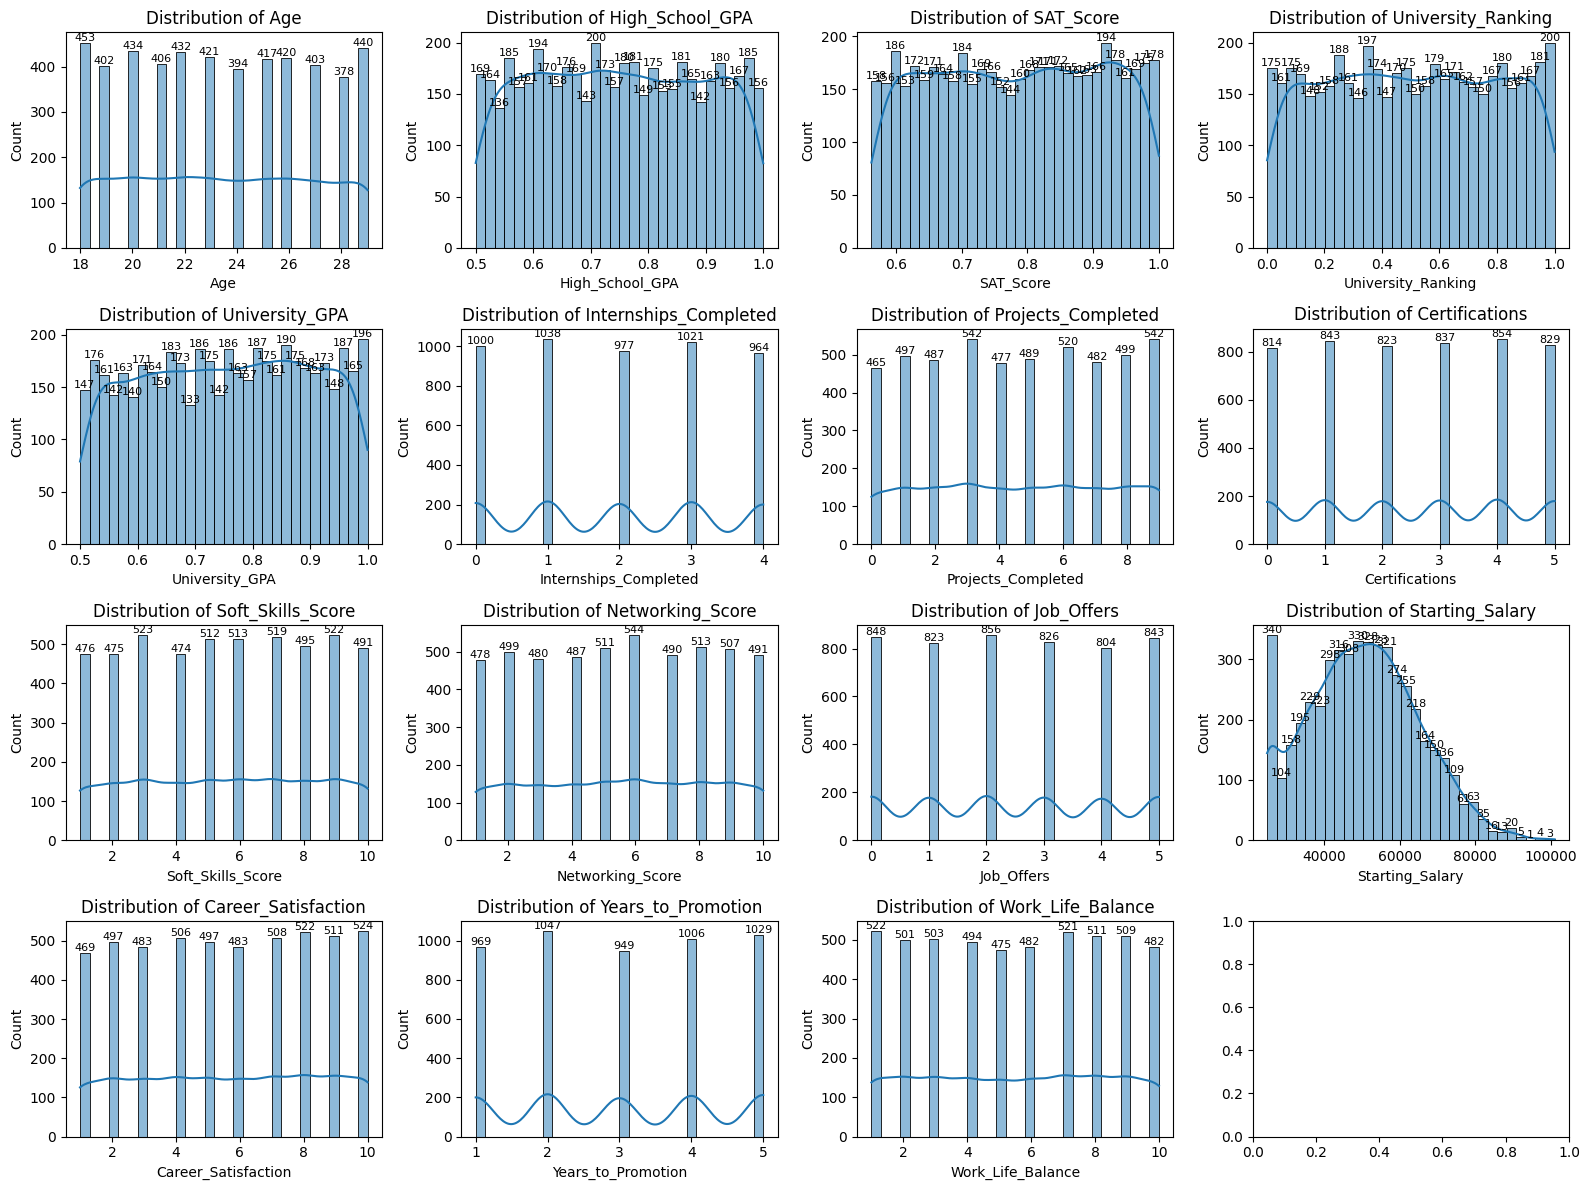

In [8]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(16, 12))
axes = axes.flatten()

for ax, col in zip(axes, df_numeric.columns):
    sns.histplot(df_numeric[col], bins=30, kde=True, ax=ax)
    ax.set_title(f"Distribution of {col}")

    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            ax.annotate(f'{int(height)}', 
                        (p.get_x() + p.get_width() / 2, height), 
                        ha='center', va='bottom', fontsize=8)
            

plt.tight_layout()
plt.show()

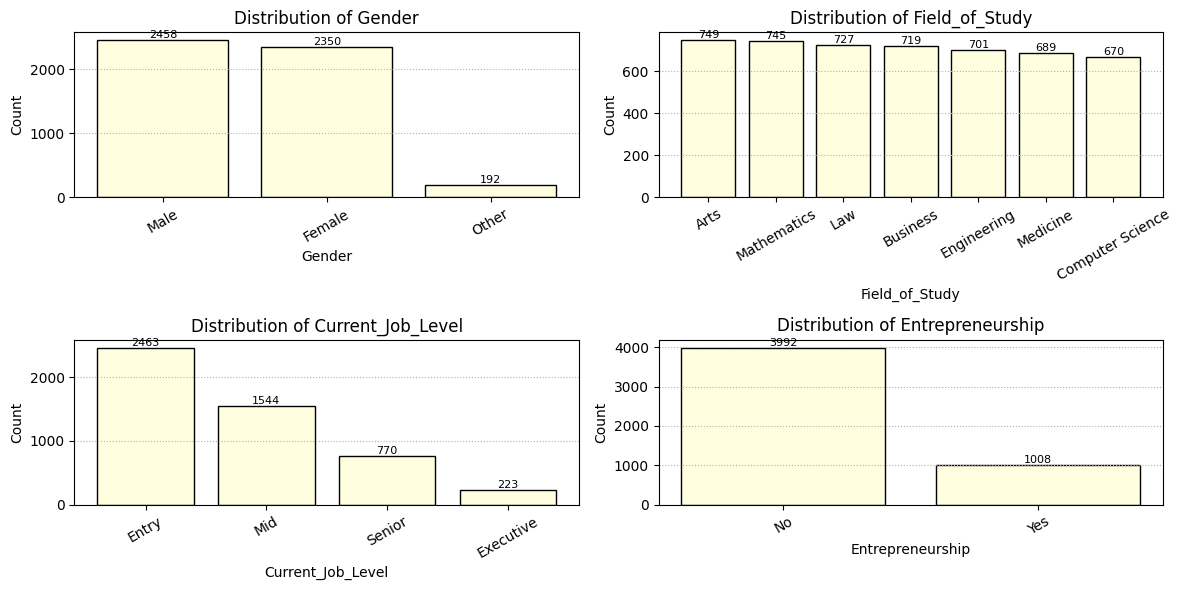

In [9]:
df_class = df.select_dtypes(include=["object"])

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 6))
axes = axes.flatten()

for i, col in enumerate(df_class.columns):
    value_counts = df_class[col].value_counts()
    bars = axes[i].bar(value_counts.index, value_counts.values, color="lightyellow", edgecolor="black")
    
    for bar in bars:
        axes[i].text(bar.get_x() + bar.get_width() / 2, 
                     bar.get_height(), 
                     str(bar.get_height()), 
                     ha='center', va='bottom', fontsize=8)

    axes[i].set_title(f"Distribution of {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Count")
    axes[i].tick_params(axis='x', rotation=30)
    axes[i].grid(axis="y", linestyle=':')

plt.tight_layout()
plt.show()

In [10]:
# features
X = df.drop(['Starting_Salary', 'Career_Satisfaction', 'Years_to_Promotion', 'Work_Life_Balance', 'Entrepreneurship'], axis=1)

# targets (categorical and numerical)
y_reg = df[['Starting_Salary', 'Career_Satisfaction', 'Years_to_Promotion', 'Work_Life_Balance']]  # we use regression
y_class = df[['Entrepreneurship']]  # we use classification (keep it like column-vector frame to save the feature name)

# split
X_train, X_test, y_reg_train, y_reg_test, y_class_train, y_class_test = train_test_split(X, y_reg, y_class, test_size=0.2)

In [11]:
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
numeric_transformer = Pipeline(steps=[
    # we dont really need imputer since there is no missing values
    # ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_features = X.select_dtypes(include=['object']).columns
categorical_transformer = Pipeline(steps=[
    # we dont really need imputer since there is no missing values
    # ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

## Models Training

In [12]:
reg_models = {
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=SEED),
    "ElasticNet": ElasticNet(random_state=SEED),
    "Ridge": Ridge(random_state=SEED)
}

class_models = {
    "LinearSVC": LinearSVC(class_weight='balanced', random_state=SEED, max_iter=10000),
    "KNN": KNeighborsClassifier(),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=SEED)
}

In [13]:
# regressions models comparison
for name, model in reg_models.items():
    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('pca', PCA(n_components=0.95)),
        ('regressor', MultiOutputRegressor(model))
    ])
    scores = cross_val_score(pipe, X_train, y_reg_train, cv=5, scoring='r2')
    print(f"{name}: Mean R2 = {scores.mean():.4f}, Std = {scores.std():.4f}")

RandomForest: Mean R2 = -0.0257, Std = 0.0044
ElasticNet: Mean R2 = -0.0016, Std = 0.0010
Ridge: Mean R2 = -0.0064, Std = 0.0015


In [14]:
# classification models comparison
for name, model in class_models.items():
    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('pca', PCA(n_components=0.95)),
        ('classifier', model)
    ])
    # target is conver to common 1d array from column vector
    scores = cross_val_score(pipe, X_train, y_class_train.values.ravel(), cv=5, scoring='accuracy')
    print(f"{name}: Mean Accuracy = {scores.mean():.4f}, Std = {scores.std():.4f}")

LinearSVC: Mean Accuracy = 0.5292, Std = 0.0128
KNN: Mean Accuracy = 0.7552, Std = 0.0117
RandomForest: Mean Accuracy = 0.7908, Std = 0.0013


## Check Results and Save models

In [15]:
best_reg_model = ElasticNet(random_state=SEED)
best_reg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=0.95)),
    ('regressor', MultiOutputRegressor(best_reg_model))
])
best_reg_pipeline.fit(X_train, y_reg_train);

In [16]:
y_reg_pred = best_reg_pipeline.predict(X_test)

reg_metrics = {}
for i, col in enumerate(y_reg.columns):
        mse = mean_squared_error(y_reg_test.iloc[:, i], y_reg_pred[:, i])
        r2 = r2_score(y_reg_test.iloc[:, i], y_reg_pred[:, i])
        reg_metrics[col] = {'MSE': mse, 'RMSE': np.sqrt(mse), 'R2': r2}
pprint(reg_metrics)

{'Career_Satisfaction': {'MSE': 7.8980050625,
                         'R2': -0.0034066080342860516,
                         'RMSE': np.float64(2.8103389586489387)},
 'Starting_Salary': {'MSE': 223486207.90291688,
                     'R2': -0.006640373909555519,
                     'RMSE': np.float64(14949.455103879769)},
 'Work_Life_Balance': {'MSE': 8.041248062500001,
                       'R2': -5.8832948316656086e-05,
                       'RMSE': np.float64(2.8357094460646)},
 'Years_to_Promotion': {'MSE': 2.0158090625,
                        'R2': -2.5114048785024323e-06,
                        'RMSE': np.float64(1.4197919081682358)}}


In [17]:
best_class_model = RandomForestClassifier(n_estimators=100, random_state=SEED)
best_class_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=0.95)),
    ('classifier', best_class_model)
])
best_class_pipeline.fit(X_train, y_class_train.values.ravel());

In [18]:
y_class_pred = best_class_pipeline.predict(X_test)
pprint(classification_report(y_class_test, y_class_pred))

('              precision    recall  f1-score   support\n'
 '\n'
 '          No       0.82      1.00      0.90       822\n'
 '         Yes       0.00      0.00      0.00       178\n'
 '\n'
 '    accuracy                           0.82      1000\n'
 '   macro avg       0.41      0.50      0.45      1000\n'
 'weighted avg       0.68      0.82      0.74      1000\n')


In [19]:
os.makedirs("models", exist_ok=True)
os.makedirs("features", exist_ok=True)

# save input and output features
joblib.dump(list(X.columns), "features/input_features.pkl")
joblib.dump(list(y_reg.columns), "features/num_out_features.pkl")
joblib.dump(list(y_class.columns), "features/cat_out_features.pkl")

# save the models
joblib.dump(best_reg_pipeline, "models/reg_model.pkl")
joblib.dump(best_class_pipeline, "models/class_model.pkl")

['models/class_model.pkl']